# PyPerceive to select and load Percept recordings 

## 0a. Loading default packages and functions

In [294]:
# Importing Python and external packages
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## 0b. Loading pyPerceive functions

In [ ]:
def add_and_set_code_folder_in_notebook():
    """
    while working in the local pyPerceive repo,
    find and set path to the PyPerceive code folder

    use function in notebook first, to locate the local
    repo and enable import of pyPerceive functions
    """
    project_path = os.getcwd()

    while project_path[-10:] != 'PyPerceive':
        project_path = os.path.dirname(project_path)

    code_path = os.path.join(project_path, 'code')
    sys.path.append(code_path)

    # change directory to code path
    os.chdir(code_path)
    
    return print(f'working dir set to: {code_path}')


In [ ]:
## MAIN FUNCTION FOR DATA IMPORT

# change working directory to ensure correct loading of own functions
add_and_set_code_folder_in_notebook()

# import main class to work with
from PerceiveImport.classes import main_class


In [ ]:
## IMPORT ALL SUB CLASSES AND FUNCTIONS FOR DEBUGGING
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class, chronic_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#### Function created for stim-detection

In [289]:
from scipy.signal import find_peaks

def find_LFP_sync_artefact(
    lfp_data: np.ndarray, fs: int = 250,
    use_kernel: str = '1',
):
    """
    Function that finds artefacts caused by
    switching stimulation on and off.
    For correct functioning, the LFP dat should
    start in stim-off, and typically short pulses
    are given (without ramping).
    The function uses a kernel which mimics the stimulation-
    artefact. This kernel is multiplied with time-series
    snippets of the same length. If the time-serie is
    similar to the kernel, the dot-product is high, and this
    indicates a stim-artefact.

    Input:
        - lfp_data: single channel as np.ndarray (the function
            automatically inverts the signal if first a positive
            peak is found, this indicates an inverted signal)
        - fs: sampling frequency
        - use_kernel: decides whether kernel 1 or 2 is used,
            kernel 1 is straight-forward and finds a steep decrease,
            kernel 2 mimics the steep decrease and slow
            recovery of the signal.
    
    Returns:
        - list of idx: a list with all stim-artefact starts. This
            also contains stim-artefacts not happening at the
            beginning or end of the recording. These have to be
            selected by the user afterwards.
    """
    signal_inverted = False  # defaults false

    # checks correct input for use_kernel variable
    assert use_kernel in ['1', '2'], 'use_kernel incorrect'

    # kernel 1 only searches for the steep decrease
    # kernel 2 is more custom and takes into account the steep decrease and slow recover
    kernels = {'1': np.array([1, -1]),
               '2': np.array([1, 0, -1] + list(np.linspace(-1, 0, 20)))}
    ker = kernels[use_kernel]
    
    # get dot-products between kernel and time-serie snippets
    res = []  # store results of dot-products
    for i in np.arange(0, len(lfp_data) - len(ker)):
        res.append(ker @ lfp_data[i:i+len(ker)])  # calculate dot-product of vectors
        # the dot-product result is high when the timeseries snippet
        # is very similar to the kernel
    res = np.array(res)  # convert list to array

    # # normalise dot product results
    res = res / max(res)

    # use peak of kernel dot products
    pos_idx = find_peaks(x=res, height=.5 * max(res[:fs*10]),
                        distance=fs)[0]
    neg_idx = find_peaks(x=-res, height=-.5 * min(res[:fs*10]),
                        distance=fs)[0]
        
    # check whether signal is converted
    if neg_idx[0] < pos_idx[0]:
        # the first peak should be POSITIVE
        # if NEG peak before POS then signal is inverted
        print('signal is inverted')
        signal_inverted = True

    # return either POS or NEG peak-indices based on normal or inverted signal
    if not signal_inverted:
        return pos_idx  # this is for 'normal' signal

    elif signal_inverted:
        return neg_idx  # if signal is inverted


## 1. Data Loading for Streaming and Survey

In [226]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

norm = main_class.PerceiveData(
    sub = "020", 
    incl_modalities=['streaming',],
    incl_session = ["fu23m"],
    incl_condition =['m1s0'],
    incl_task = ["rest"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
)



	### WARNING: NaNs in Metadata Table sub-020 ###
NaNs in: sub-20210329PStn_ses-1956031911000059_run-CHRONIC20220530063203.mat
NaNs in: sub-20210329PStn_ses-1956031911000059_run-IS20230221101200.mat
NaNs in: sub-20210329PStn_ses-2023022111165459_run-CHRONIC20220530075203.mat
NaNs in: sub-20210329PStn_ses-2023022111165459_run-IS20230221121300.mat
NaNs in: sub-20210329PStn_ses-2023022111165459_run-IS20230221121500.mat
Creating RawArray with float64 data, n_channels=6, n_times=41375
    Range : 0 ... 41374 =      0.000 ...   165.496 secs
Ready.


[ 1599  2802  3867 37989 38774 39908]


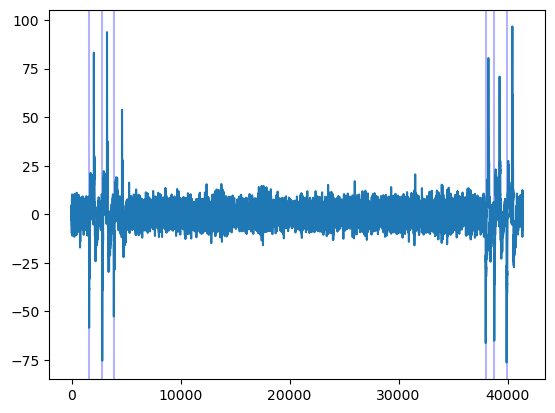

In [288]:
# define data
normdata = norm.streaming.fu23m.m1s0.rest.run1.data
ch_i = 0
lfp_sig = normdata.get_data()[ch_i]
# get stim-artefact indices
art_idx = find_LFP_sync_artefact(
    lfp_data=lfp_sig, fs=250,
    use_kernel='2',
)
print(art_idx)
for xline in art_idx:
    plt.axvline(x=xline, ymin=min(lfp_sig), ymax=max(lfp_sig),
                color='blue', alpha=.3,)

plt.plot(lfp_sig)

# plt.xlim(1550, 2000)

plt.show()

In [260]:
inv = main_class.PerceiveData(
    sub = "019", 
    incl_modalities=['streaming',],
    incl_session = ["fu24m"],
    incl_condition =['m1s1'],
    incl_task = ["fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
)



	### WARNING: NaNs in Metadata Table sub-019 ###
NaNs in: sub019_ses-2021042207162599_run-BrainSense20210422074600.mat
NaNs in: sub019_ses-2021042207162599_run-BrainSense20210422075600.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081000.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081300.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081500.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081900.mat
NaNs in: sub019_ses-2021070506275097_run-BrainSense20210705070700.mat
NaNs in: sub019_ses-2021070506275097_run-BrainSense20210705072100.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705074000.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705074300.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705075000.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705075800.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705081000.mat
NaNs in: sub019_ses-2021070508345297_run-BrainSense20210705084300.mat
Na

signal is inverted
[ 1075  2427  3651  6559 47807 49345 50661]


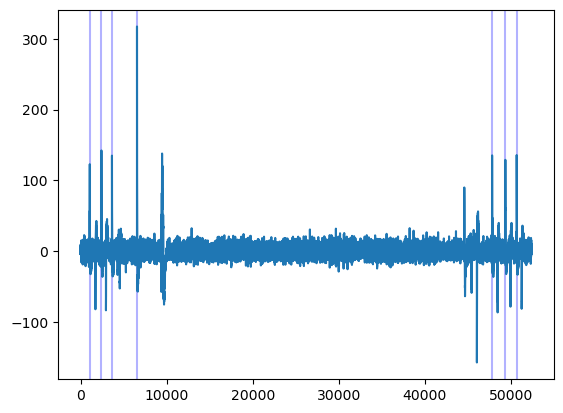

In [292]:
# define lfp data
invdata = inv.streaming.fu24m.m1s1.fingerTap.run1.data
ch_i = 1
lfp_sig = invdata.get_data()[ch_i]

# get stim-artefact indices
art_idx = find_LFP_sync_artefact(
    lfp_data=lfp_sig, fs=250,
    use_kernel='1',
)

print(art_idx)
for xline in art_idx:
    plt.axvline(x=xline, ymin=min(lfp_sig), ymax=max(lfp_sig),
                color='blue', alpha=.3,)

plt.plot(lfp_sig)

# plt.xlim(400, 5000)

plt.show()